<a href="https://colab.research.google.com/github/itz-abhay/U-Net-Hyper_kvasir-Segmentation/blob/main/uNET_Hyper_kvasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import zipfile
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/U Net data/hyper-kvasir-segmented-images.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/hyper-kvasir-segmented-images')

In [ ]:
image_path = "/content/hyper-kvasir-segmented-images/segmented-images"
mask_path = "/content/hyper-kvasir-segmented-images/segmented-images/masks"

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Define the paths to the images and masks folders
images_folder = '/content/hyper-kvasir-segmented-images/segmented-images/images'
masks_folder = '/content/hyper-kvasir-segmented-images/segmented-images/masks'

# Get the list of image and mask filenames
image_filenames = os.listdir(images_folder)
mask_filenames = os.listdir(masks_folder)

# Define image and mask dimensions
input_height, input_width = 256, 256  # Adjust as needed

# Create empty lists to store data
images_data = []
masks_data = []

for image_filename, mask_filename in zip(image_filenames, mask_filenames):
    # Load and preprocess images
    image = load_img(os.path.join(images_folder, image_filename), target_size=(input_height, input_width))
    image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    images_data.append(image)

    # Load and preprocess masks
    mask = load_img(os.path.join(masks_folder, mask_filename), target_size=(input_height, input_width), color_mode='grayscale')
    mask = img_to_array(mask) / 255.0
    masks_data.append(mask)

# Convert data lists to arrays
images_data = np.array(images_data)
masks_data = np.array(masks_data)

print("Images shape:", images_data.shape)
print("Masks shape:", masks_data.shape)


Images shape: (1000, 256, 256, 3)
Masks shape: (1000, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Your data and labels
x, y = images_data, masks_data

# Split the data into training (70%), validation (15%), and test (15%) sets
x_train,x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
num_classes = 1

inputs = tf.keras.layers.Input((input_height, input_width, 3))

#Contraction path
c1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)


u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)


u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)


outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

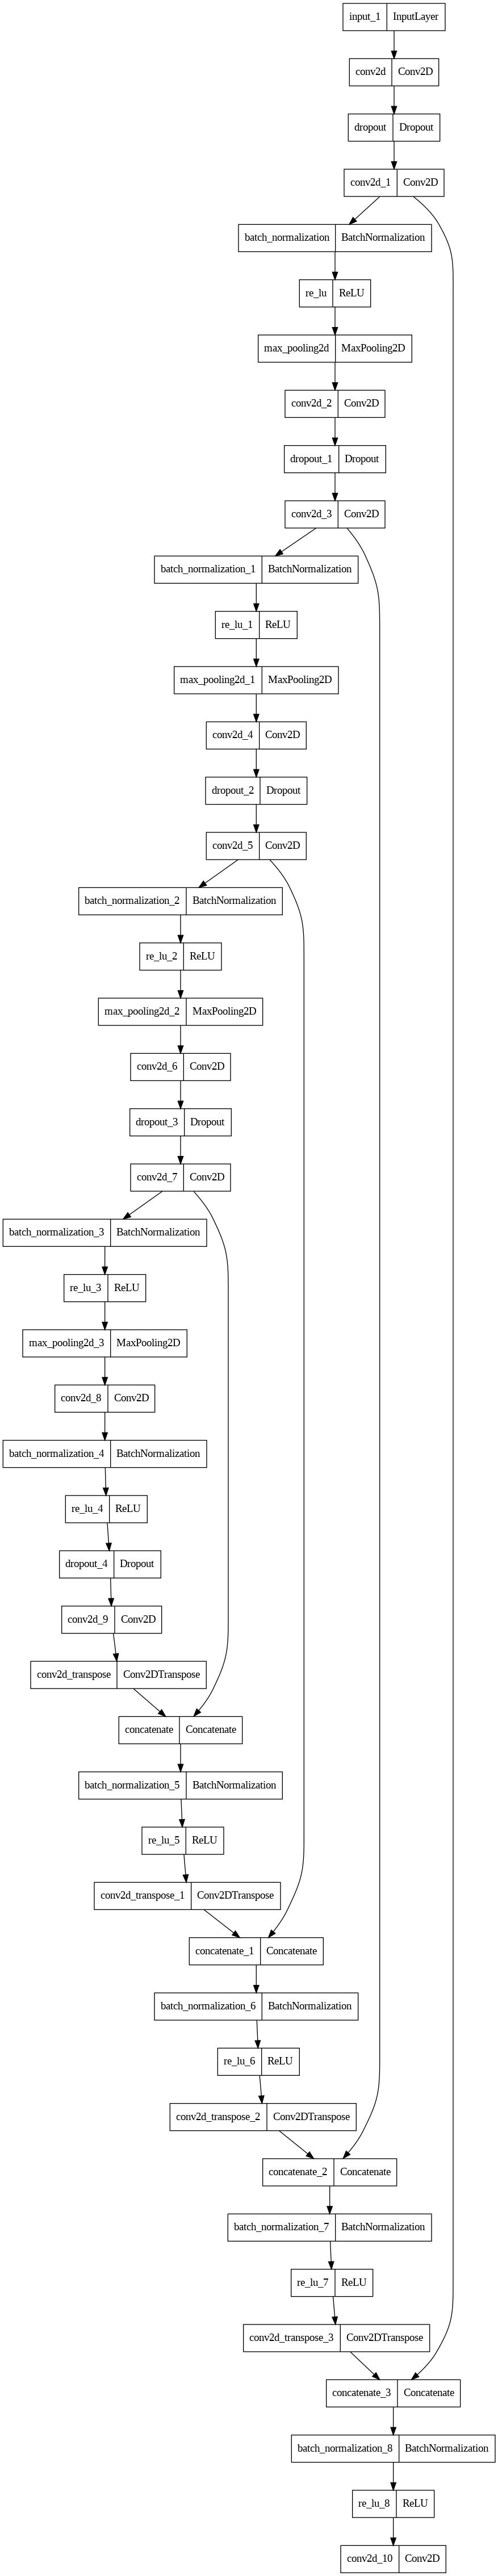

In [ ]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, "model.png")

In [ ]:
callbacks = [
        # tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
44/44 [==============================] - 72s 905ms/step - loss: 0.4448 - accuracy: 0.8117 - val_loss: 1.3960 - val_accuracy: 0.3696
Epoch 2/100
44/44 [==============================] - 26s 598ms/step - loss: 0.3568 - accuracy: 0.8384 - val_loss: 0.7453 - val_accuracy: 0.5822
Epoch 3/100
44/44 [==============================] - 27s 604ms/step - loss: 0.3380 - accuracy: 0.8440 - val_loss: 0.3901 - val_accuracy: 0.8293
Epoch 4/100
44/44 [==============================] - 27s 606ms/step - loss: 0.3293 - accuracy: 0.8489 - val_loss: 0.3556 - val_accuracy: 0.8460
Epoch 5/100
44/44 [==============================] - 27s 612ms/step - loss: 0.3209 - accuracy: 0.8521 - val_loss: 0.3439 - val_accuracy: 0.8473
Epoch 6/100
44/44 [==============================] - 27s 610ms/step - loss: 0.3126 - accuracy: 0.8584 - val_loss: 0.3419 - val_accuracy: 0.8437
Epoch 7/100
44/44 [==============================] - 27s 604ms/step - loss: 0.3109 - accuracy: 0.8603 - val_loss: 0.3634 - val_accuracy:

In [ ]:
# Save the model weights to a file
model.save_weights('uNET_20101_model_weights.h5')

# Download the saved weights file
from google.colab import files
files.download('uNET_20101_model_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

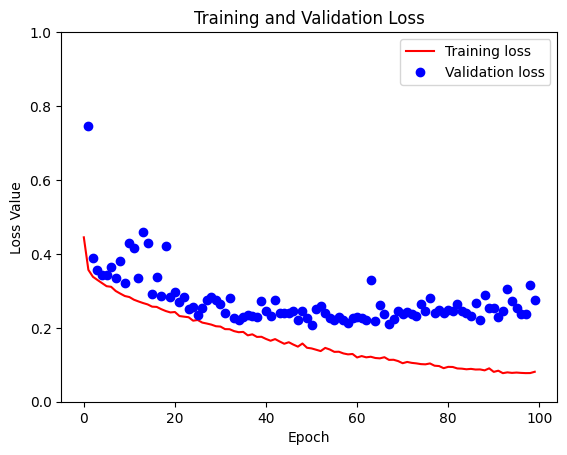

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


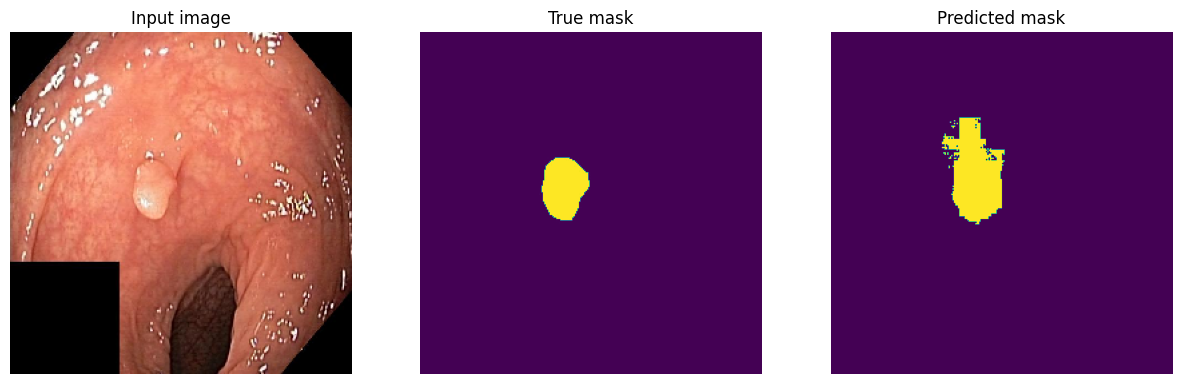

1/1 [==============================] - 0s 29ms/step


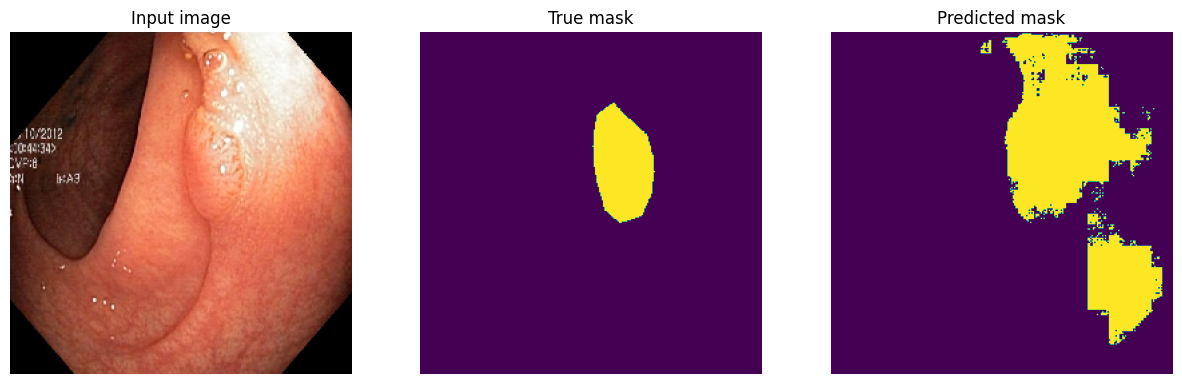

1/1 [==============================] - 0s 35ms/step


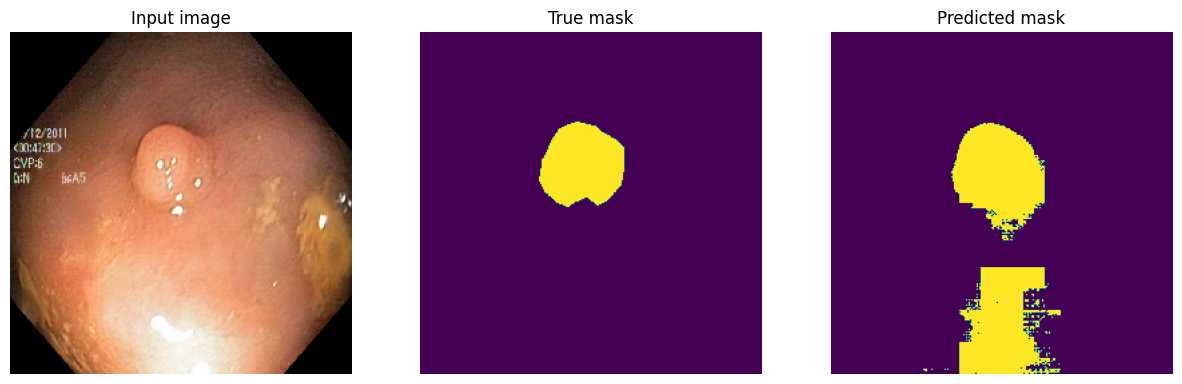

1/1 [==============================] - 0s 35ms/step


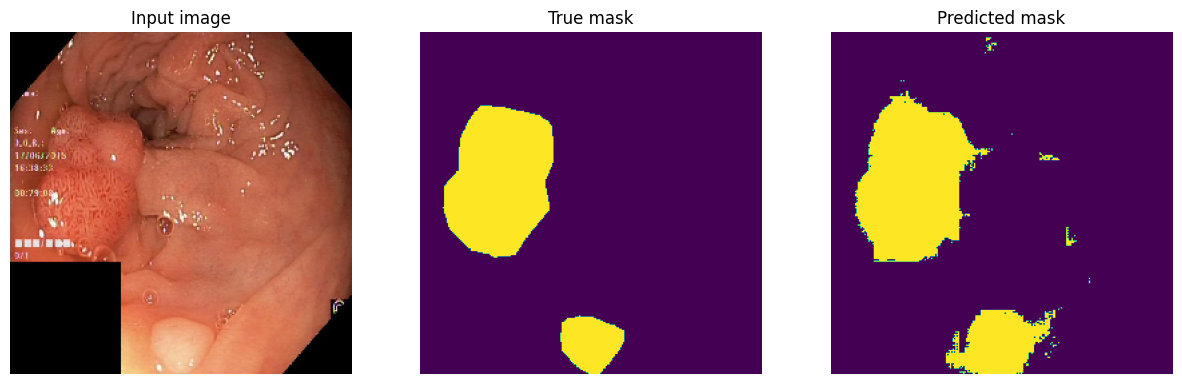

1/1 [==============================] - 0s 36ms/step


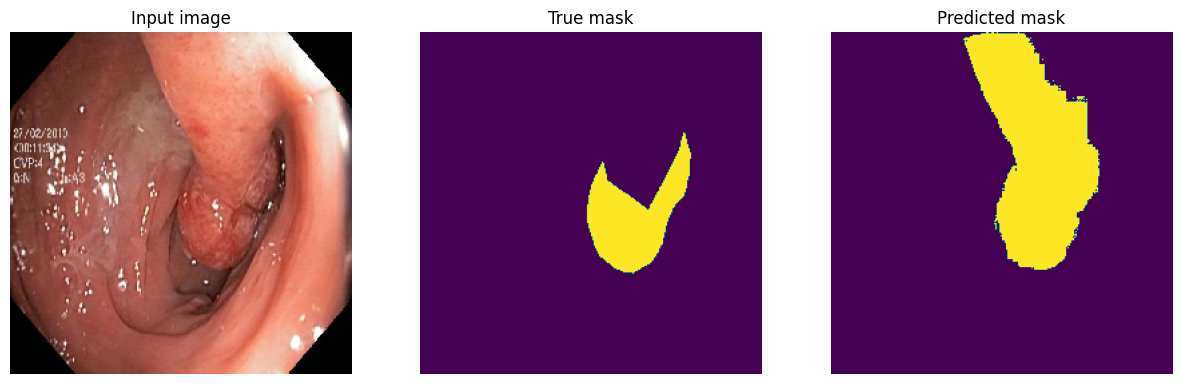

1/1 [==============================] - 0s 52ms/step


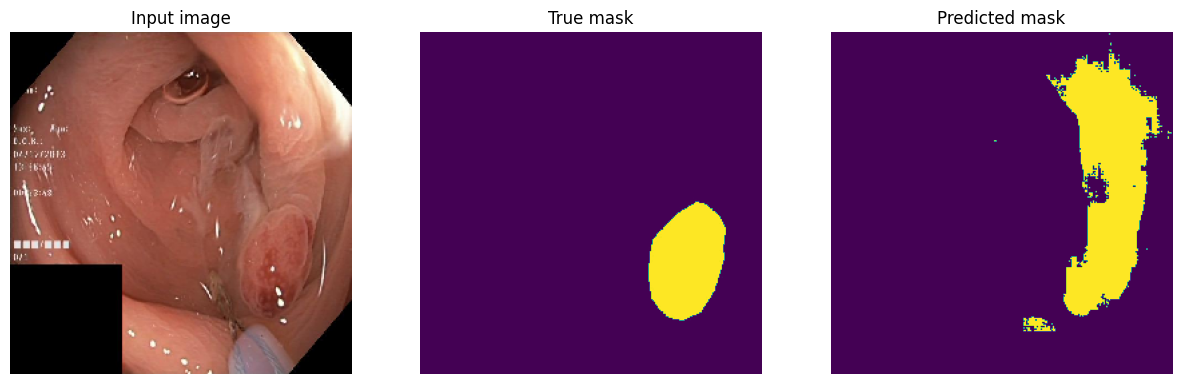

1/1 [==============================] - 0s 35ms/step


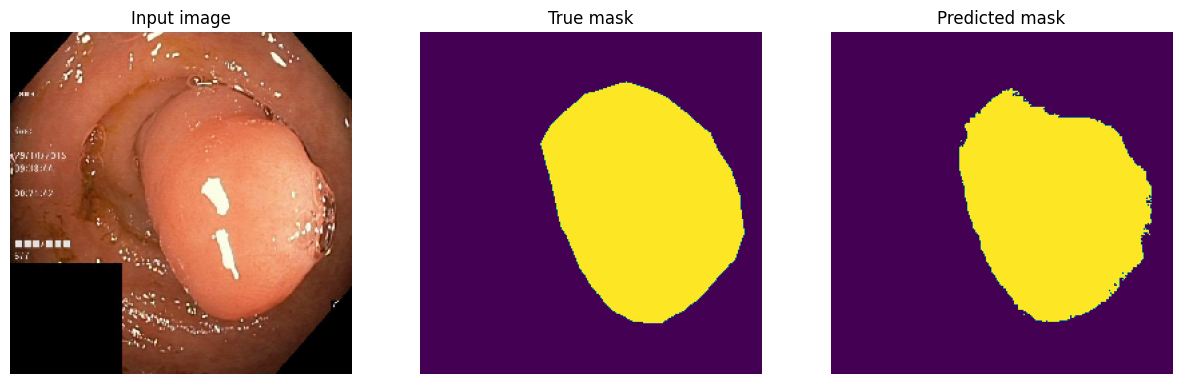

1/1 [==============================] - 0s 39ms/step


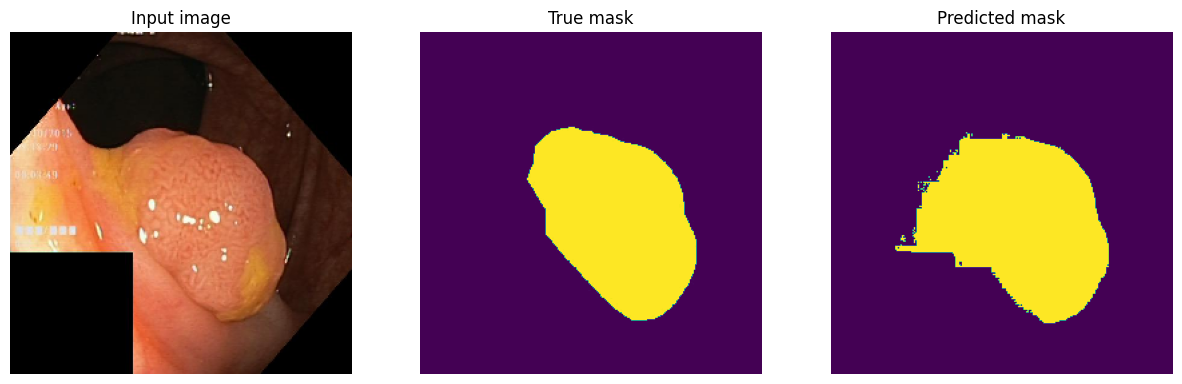

1/1 [==============================] - 0s 38ms/step


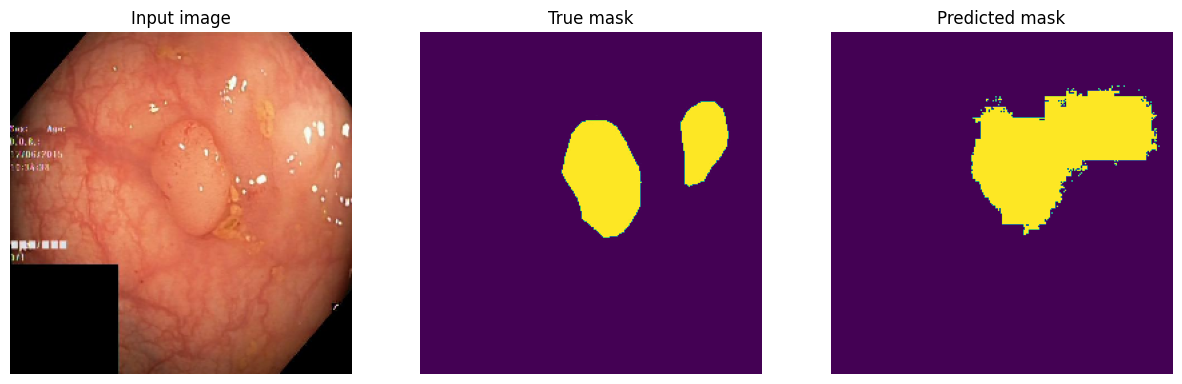

1/1 [==============================] - 0s 43ms/step


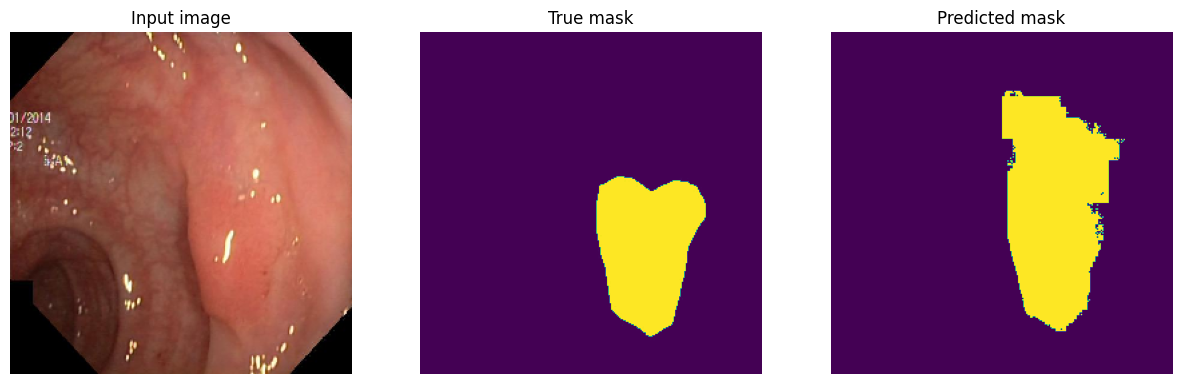

In [ ]:
import random
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


#Calling above function 10 times
for i in range(10):
  i = random.randint(0, len(x_val))
  sample_image = x_test[i]
  sample_mask = y_test[i]
  prediction = model.predict(sample_image[tf.newaxis, ...])[0]
  predicted_mask = (prediction > 0.5).astype(np.float32)
  #calling the above function
  display([sample_image, sample_mask,predicted_mask])